In [23]:
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import re
import requests

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc
plt.rcParams.update({'font.size': 102})
matplotlib.rcParams['pdf.fonttype'] = 42

from pywaffle import Waffle

%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

# Annual ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm`

In [24]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub_annual.htm")
doc = BeautifulSoup(response.text)

In [25]:
stations = []
lines = ""
for row in doc.find_all("tr")[4:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = one + total
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        stations.append(station)
    except: pass

In [26]:
df = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
df = df.dropna()

In [27]:
## Changing the numbers to actual numbers

cols = ['2013', '2014','2015','2016','2017','2018']
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
df.Rank = df.Rank.astype(int)

## Large analysis

In [28]:
df.groupby('Borough').Station.count().values

array([157, 121,  78,  68], dtype=int64)

In [29]:
def get_change(x):
    return x['2018'] - x['2017']

df['17-18 change'] = df.apply(get_change, axis=1)

## Total loss by year, boroughs condensed

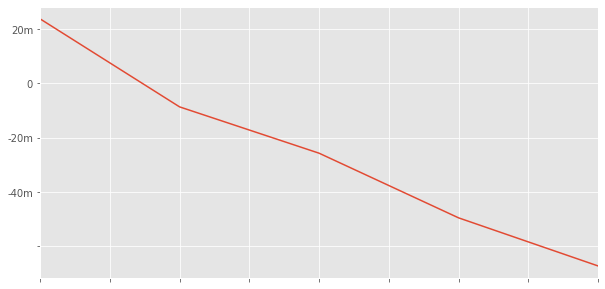

In [30]:


total={}
total['index'] = [0]
total['13-14'] = (df['2014'].sum() - df['2013'].sum())
total['14-15'] = (df['2015'].sum() - df['2014'].sum()) 
total['15-16'] = (df['2016'].sum() - df['2015'].sum())
total['16-17'] = (df['2017'].sum() - df['2016'].sum())
total['17-18'] = (df['2018'].sum() - df['2017'].sum())
total = pd.DataFrame(total)
total = total.transpose()
ax=total.tail(5).plot(legend=False, figsize=(10,5))
ax.set_yticklabels(['','','-40m','-20m','0','20m','40m'])
ax.set_xticklabels('')

plt.savefig("images/header_image.pdf")

##  Total ridership by borough

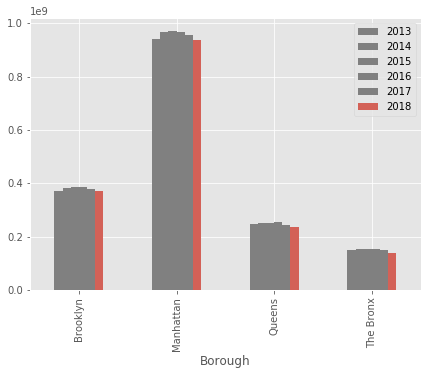

In [31]:
df.groupby('Borough').sum().plot(kind='bar', y=['2013','2014','2015','2016','2017','2018'], color=['gray','gray','gray','gray','gray','#D36157'], figsize=(7, 5))

## Total loss per borough per year

In [32]:
df2={}
df2['borough'] = ['Brooklyn','Manhattan','Queens','The Bronx']
df2['13-14'] = (df.groupby('Borough')['2014'].sum().values - df.groupby('Borough')['2013'].sum().values)
df2['14-15'] = (df.groupby('Borough')['2015'].sum().values - df.groupby('Borough')['2014'].sum().values)
df2['15-16'] = (df.groupby('Borough')['2016'].sum().values - df.groupby('Borough')['2015'].sum().values)
df2['16-17'] = (df.groupby('Borough')['2017'].sum().values - df.groupby('Borough')['2016'].sum().values)
df2['17-18'] = (df.groupby('Borough')['2018'].sum().values - df.groupby('Borough')['2017'].sum().values)
df2 = pd.DataFrame(df2)
df2.head()
# df.groupby('Borough').Station.count().values

,borough,13-14,14-15,15-16,16-17,17-18
0,Brooklyn,10332661.0,4823755.0,-3008378.0,-5167670.0,-9141248.0
1,Manhattan,24960142.0,5029404.0,-3937801.0,-10821930.0,-19055757.0
2,Queens,4990699.0,1644794.0,452828.0,-9667468.0,-9027716.0
3,The Bronx,3398860.0,-192694.0,761151.0,-3858174.0,-9981906.0


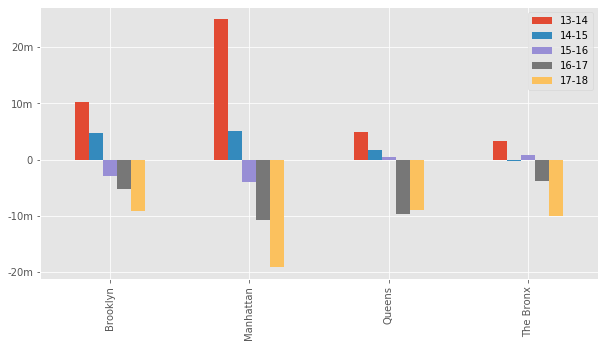

In [33]:
ax = df2.plot(kind='bar', x='borough', y=['13-14','14-15','15-16','16-17','17-18'], figsize=(10,5))
ax.set_xlabel('')
ax.set_yticklabels(['','-20m','-10m','0','10m','20m'])

plt.savefig("images/annual_ridership_by_borough_2.svg", bbox_inches='tight')

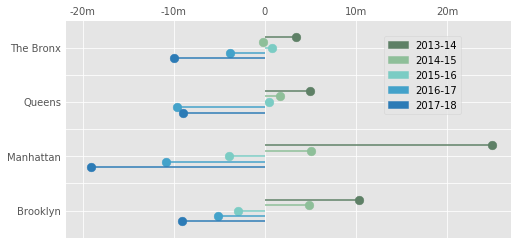

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_ylim([-1,7])
ax.set_xlim([-22000000, 27000000])
ax.xaxis.tick_top()
ax.set_yticklabels(['','Brooklyn','','Manhattan','','Queens','','The Bronx',''])
ax.set_xticklabels(['','-20m','-10m','0','10m','20m'])
# ax.set_title('Change in annual subway ridership from year to year')

ax.hlines(xmin=0, xmax=df2['13-14'], y=[(0+.4), (2+.4), (4+.4), (6+.4)], color='#5E8066')
legend = [ax.scatter(x=df2['13-14'], y=[(0+.4), (2+.4), (4+.4), (6+.4)], s=75, color='#5E8066')]

ax.hlines(xmin=0, xmax=df2['14-15'], y=[(0+.2), (2+.2), (4+.2), (6+.2)], color='#8EBF99')
legend = [ax.scatter(x=df2['14-15'], y=[(0+.2), (2+.2), (4+.2), (6+.2)], s=75, color='#8EBF99')]

ax.hlines(xmin=0, xmax=df2['15-16'], y=[(0), (2), (4), (6)], color='#7bccc4')
legend = [ax.scatter(x=df2['15-16'], y=[(0), (2), (4), (6)], s=75, color='#7bccc4')]

ax.hlines(xmin=df2['16-17'], xmax=0, y=[(0-.2), (2-.2), (4-.2), (6-.2)], color='#43a2ca')
legend = [ax.scatter(x=df2['16-17'], y=[(0-.2), (2-.2), (4-.2), (6-.2)], s=75, color='#43a2ca')]

ax.hlines(xmin=df2['17-18'], xmax=0, y=[(0-.4), (2-.4), (4-.4), (6-.4)], color='#2c7bb6')
legend = [ax.scatter(x=df2['17-18'], y=[(0-.4), (2-.4), (4-.4), (6-.4)], s=75, color='#2c7bb6')]

three_four = mpatches.Patch(color='#5E8066', label='2013-14')
four_five = mpatches.Patch(color='#8EBF99', label='2014-15')
five_six = mpatches.Patch(color='#7bccc4', label='2015-16')
six_seven = mpatches.Patch(color='#43a2ca', label='2016-17')
seven_eight = mpatches.Patch(color='#2c7bb6', label="2017-18")

ax.legend(handles=[three_four, four_five,five_six,six_seven,seven_eight], bbox_to_anchor=(.9, .95))
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig("images/annual_ridership_by_borough_1.svg", bbox_inches='tight', transparent=True)

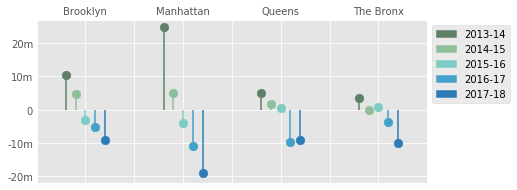

In [35]:
fig, ax = plt.subplots(figsize=(7,3))
ax.set_xlim([-1,7])
ax.set_ylim([-22000000, 27000000])
ax.xaxis.tick_top()
ax.set_xticklabels(['','Brooklyn','','Manhattan','','Queens','','The Bronx',''])
ax.set_yticklabels(['','-20m','-10m','0','10m','20m'])
# # ax.set_title('Change in annual subway ridership from year to year')

ax.vlines(ymin=0, ymax=df2['13-14'], x=[(0-.4), (2-.4), (4-.4), (6-.4)], color='#5E8066')
legend = [ax.scatter(y=df2['13-14'], x=[(0-.4), (2-.4), (4-.4), (6-.4)], s=75, color='#5E8066')]

ax.vlines(ymin=0, ymax=df2['14-15'], x=[(0-.2), (2-.2), (4-.2), (6-.2)], color='#8EBF99')
legend = [ax.scatter(y=df2['14-15'], x=[(0-.2), (2-.2), (4-.2), (6-.2)], s=75, color='#8EBF99')]

ax.vlines(ymin=0, ymax=df2['15-16'], x=[(0), (2), (4), (6)], color='#7bccc4')
legend = [ax.scatter(y=df2['15-16'], x=[(0), (2), (4), (6)], s=75, color='#7bccc4')]

ax.vlines(ymin=df2['16-17'], ymax=0, x=[(0+.2), (2+.2), (4+.2), (6+.2)], color='#43a2ca')
legend = [ax.scatter(y=df2['16-17'], x=[(0+.2), (2+.2), (4+.2), (6+.2)], s=75, color='#43a2ca')]

ax.vlines(ymin=df2['17-18'], ymax=0, x=[(0+.4), (2+.4), (4+.4), (6+.4)], color='#2c7bb6')
legend = [ax.scatter(y=df2['17-18'], x=[(0+.4), (2+.4), (4+.4), (6+.4)], s=75, color='#2c7bb6')]


three_four = mpatches.Patch(color='#5E8066', label='2013-14')
four_five = mpatches.Patch(color='#8EBF99', label='2014-15')
five_six = mpatches.Patch(color='#7bccc4', label='2015-16')
six_seven = mpatches.Patch(color='#43a2ca', label='2016-17')
seven_eight = mpatches.Patch(color='#2c7bb6', label="2017-18")

ax.legend(handles=[three_four, four_five,five_six,six_seven,seven_eight], bbox_to_anchor=(1, 1))
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig("images/annual_ridership_by_borough_3.svg", bbox_inches='tight', transparent=True)

## Change in ridership from 2017-18

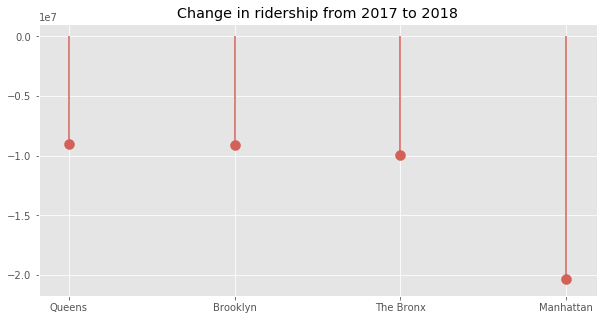

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.vlines(ymin=[0], ymax=df.groupby('Borough')['17-18 change'].sum().sort_values().iloc[::-1], x=df.groupby('Borough')['2018'].sum().index, color='#d36157')
# ax.yaxis.tick_top()
ax.set_xticklabels(['Queens','Brooklyn','The Bronx','Manhattan'])
ax.set_title('Change in ridership from 2017 to 2018')
legend = [ax.scatter(y=df.groupby('Borough')['17-18 change'].sum().sort_values().iloc[::-1], x=df.groupby('Borough')['17-18 change'].sum().index, s=100, color='#d36157')]

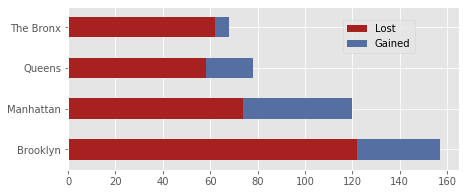

In [37]:
r = [0,1,2,3,4]
stacked_raw = {}
stacked_raw['index'] = [0, 1, 2, 3]
stacked_raw['Gained'] = (df[df['17-18 change'] > 0].groupby('Borough').Station.count())
stacked_raw['Lost'] = (df[df['17-18 change'] < 0].groupby('Borough').Station.count())
stacked = pd.DataFrame(stacked_raw)

ax = stacked.plot(kind='barh', y=['Lost','Gained'], stacked=True, color=['#a82121','#566FA3'], figsize=(7,3))
ax.legend( bbox_to_anchor=(.9, .95))
ax.set_ylabel('')
plt.savefig('images/lost_vs_gained.svg', bbox_inches='tight',transparent=True)

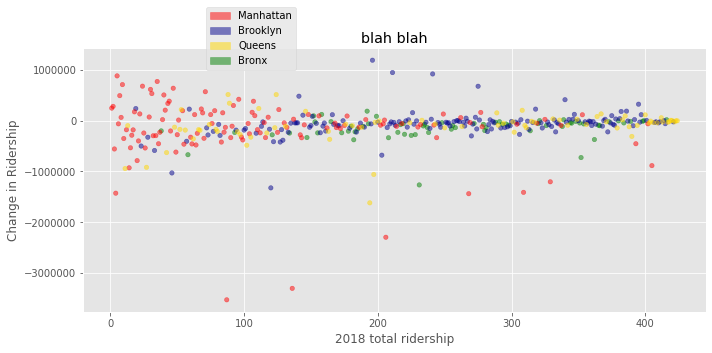

In [84]:
def build_colors(x):
    if x.Borough == "Manhattan":
        return 'red'
    elif x.Borough == "Brooklyn":
        return 'darkblue'
    elif x.Borough == "Queens":
        return 'gold'
    else:
        return 'green'

colors = df.apply(build_colors, axis=1)


ax = df.plot(kind='scatter', x='Rank', y='17-18 change', color=colors, legend=True, alpha=.5, figsize=(10,5))
ax.set_title("blah blah")

Manhattan = mpatches.Patch(color='red', alpha=.5, label='Manhattan')
Brooklyn = mpatches.Patch(color='darkblue', alpha=.5, label='Brooklyn')
Queens = mpatches.Patch(color='gold', alpha=.5, label='Queens')
Bronx = mpatches.Patch(color='green', alpha=.5, label='Bronx')

ax.legend(handles=[Manhattan, Brooklyn, Queens, Bronx], bbox_to_anchor=(.35, .9))
ax.set_ylabel('')
ax.set_xlabel('')

# ax.set_ylim(320, 450)
# ax.set_yticks([320,340,360,380,400,420, 440])
# ax.set_xticks([320,340,360,380,400,420, 440])


ax.set_xlabel("MTA's 2018 Rank")
ax.set_ylabel('Change in Ridership from 2017-18')


plt.tight_layout()
# plt.savefig('538_2.pdf', facecolor='#F0F0F0', edgecolor='none')

In [40]:
df[(df.lines.str.contains("E")) & (df['17-18 change'] > 0)].Borough.value_counts()

Manhattan    9
Queens       3
Name: Borough, dtype: int64

In [41]:
df[df.lines.str.contains("Z")]

,Station,lines,Borough,Rank,2013,2014,2015,2016,2017,2018,17-18 change
119,Broadway Junction,ZLJCA,Brooklyn,171,2948156.0,3018656.0,3133658.0,3085401.0,2911532.0,2810636,-100896.0
124,Chauncey St,ZJ,Brooklyn,341,938803.0,959091.0,1045698.0,1092483.0,1095638.0,1063828,-31810.0
136,Crescent St,ZJ,Brooklyn,299,1509290.0,1583134.0,1626727.0,1617730.0,1570485.0,1467166,-103319.0
154,Gates Av,ZJ,Brooklyn,210,1895878.0,1984486.0,2100864.0,2117787.0,2262915.0,2234908,-28007.0
181,Marcy Av,ZMJ,Brooklyn,114,3681903.0,3953628.0,4204877.0,4272443.0,4199041.0,4171666,-27375.0
184,Myrtle Av,ZMJ,Brooklyn,127,3562631.0,3523740.0,3687468.0,3764562.0,4213096.0,3789470,-423626.0
196,Norwood Av,ZJ,Brooklyn,360,1095573.0,1145643.0,1159274.0,1146658.0,1065073.0,966728,-98345.0
220,Van Siclen Av,ZJ,Brooklyn,377,913115.0,943663.0,966461.0,983370.0,910042.0,818735,-91307.0
304,Bowery,ZJ,Manhattan,319,970576.0,1057000.0,1184920.0,1223959.0,1327970.0,1275541,-52429.0
306,Broad St,ZJ,Manhattan,242,1436506.0,1662905.0,1834780.0,2064292.0,2056754.0,1967616,-89138.0


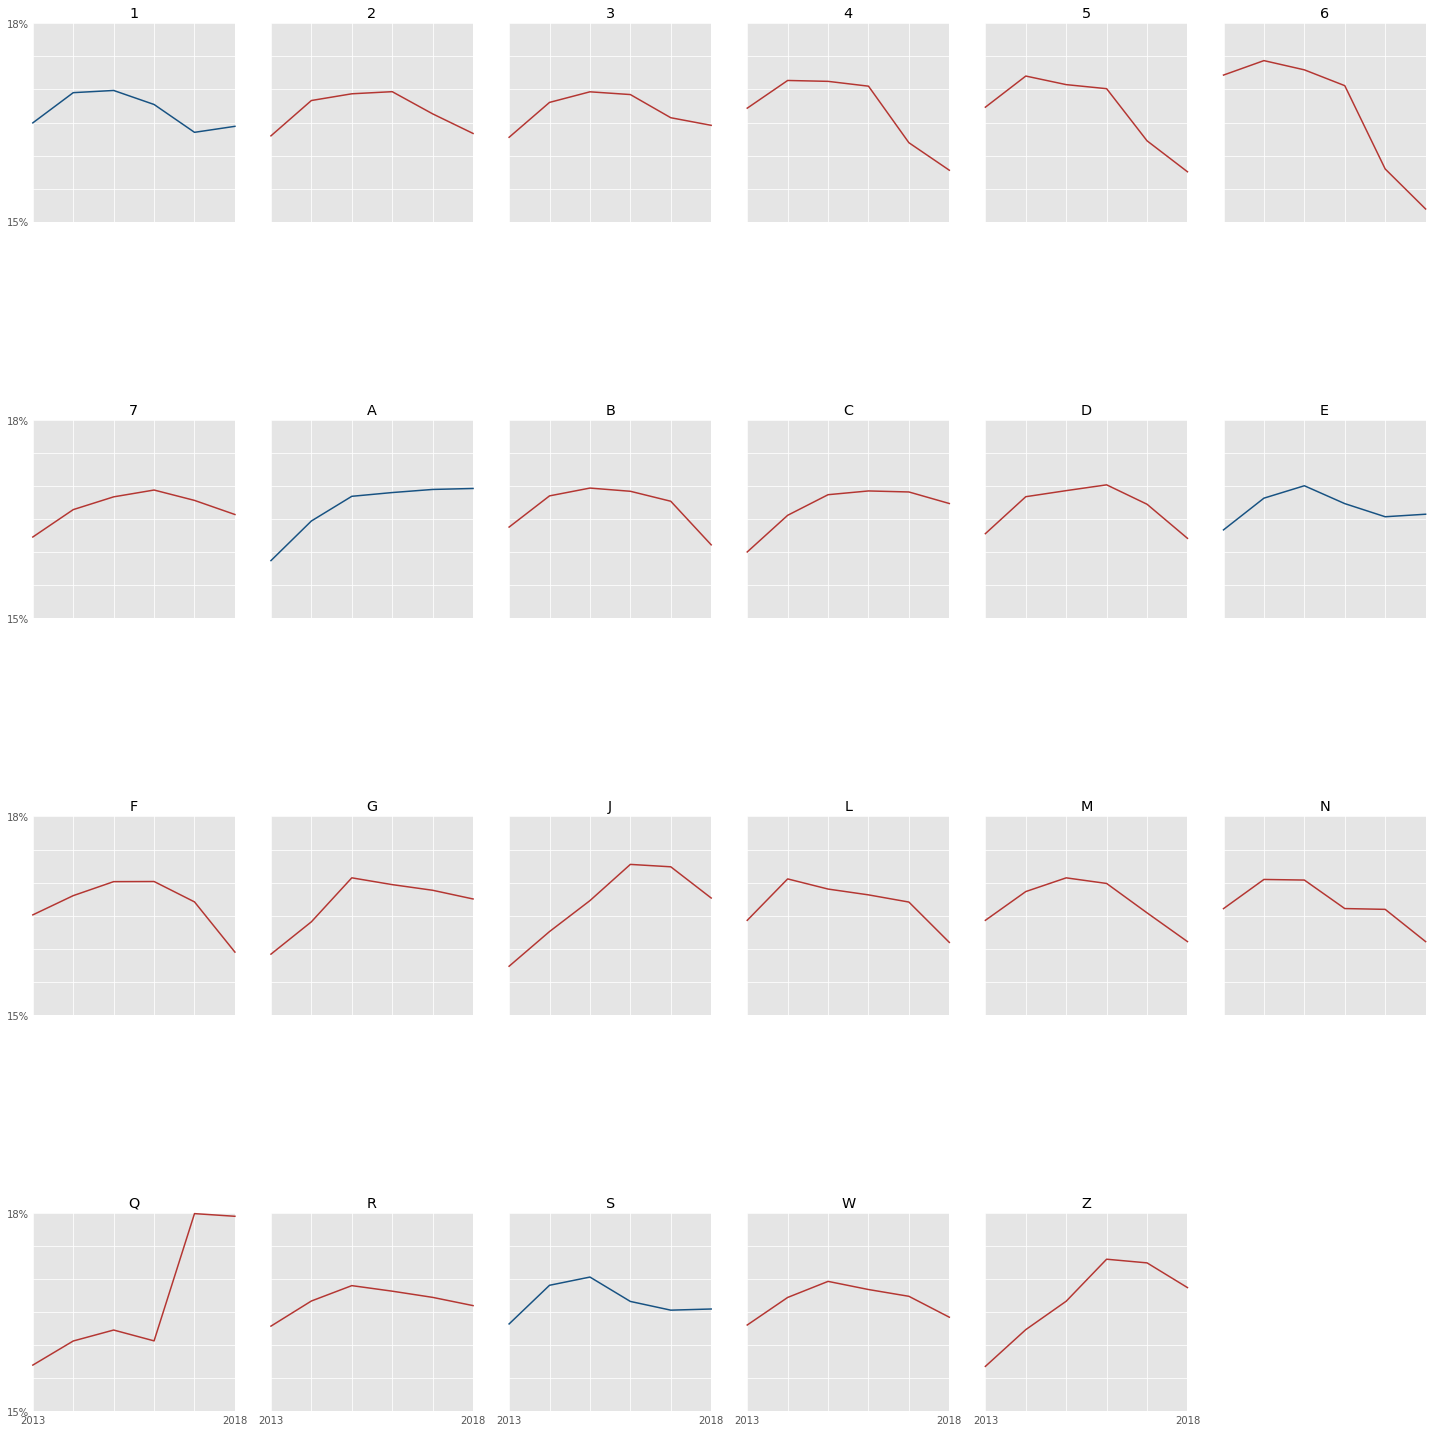

In [95]:
lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for line in lines:
    line_one = df[df.lines.str.contains(line)]
    ax = axes_list.pop(0)
    
    total = {}
    total['riders'] = [line_one['2013'].sum(),line_one['2014'].sum(),line_one['2015'].sum(),line_one['2016'].sum(),line_one['2017'].sum(),line_one['2018'].sum()]
    total['year'] = ['2013','2014','2015','2016','2017','2018']
    total = pd.DataFrame(total)
    total['17-18 change'] = total.riders[5] - total.riders[4]

    if total['17-18 change'][5] > 0:
        color =  '#175282'
    else:
        color = '#B43632'
    
    def get_percentage(x):
        return x.riders / total['riders'].sum()

    total['percentage'] = total.apply(get_percentage, axis=1)

    ax = total.plot(kind='line', x='year',y='percentage', ax=ax, title=line, legend=False, clip_on=False, color=color)
    
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_ylim(.15,.18)
    ax.set_xticklabels(['2013','','','','','2018'])
    ax.set_yticklabels(['15%','','','','','','18%'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
#     ax.set_ylim[total.riders.min()-100, total.riders.max()+100]

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
plt.tight_layout()
    
plt.subplots_adjust(hspace=1)
plt.savefig("images/all_lines_ridership.pdf")

In [ ]:
lines = ['1','2','3','4','5','6','7','A','B','C','D','E','F','G','J','L','M','N','Q','R','S','W','Z']

# We can ask for ALL THE AXES and put them into axes
fig, axes = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(20,20))
axes_list = [item for sublist in axes for item in sublist] 

for line in lines:
    line_one = df[df.lines.str.contains(line)]
    ax = axes_list.pop(0)
    
    count = {}
    count['index'] = [0]
    count['gained'] = ((line_one['17-18 change'] > 0).value_counts().sort_index().values[0]) / ((line_one['17-18 change'] > 0).value_counts().values.sum())
    count['lost'] = ((line_one['17-18 change'] > 0).value_counts().sort_index().values[1]) / ((line_one['17-18 change'] > 0).value_counts().values.sum())
    count = pd.DataFrame(count)
    
    count.plot(kind='bar', stacked=True, label=line, ax=ax, legend=False, color=['#566FA3','#B43632'])
    ax.set_title(line)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()
    
plt.tight_layout()

In [ ]:
df.to_csv("station_annual_ridership.csv", index=False)


<hr>
<hr>
<hr>

## Average weekday ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub.htm`

In [ ]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub.htm")
doc = BeautifulSoup(response.text)

In [ ]:
stations = []
lines = ""
for row in doc.find_all("tr")[5:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = one + total
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        stations.append(station)
    except: pass

In [ ]:
weekday = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
weekday = weekday.dropna()

## Changing the numbers to actual numbers
cols = ['2013', '2014','2015','2016','2017','2018']
weekday[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
weekday.Rank = weekday.Rank.astype(int)
weekday['change'] = weekday['2018'] - weekday['2017']

In [ ]:
weekday.groupby('Borough').max().plot(kind='barh', y='2018')

In [ ]:
weekday.groupby('Borough')['2018'].min()

In [ ]:
df['change'] = df['2018'] - df['2017']

In [ ]:
df.to_csv("station_weekday_ridership.csv", index=False)

## Average Weekend Ridership
`http://web.mta.info/nyct/facts/ridership/ridership_sub_weekend.htm`

In [ ]:
response = requests.get("http://web.mta.info/nyct/facts/ridership/ridership_sub_weekend.htm")
doc = BeautifulSoup(response.text)

In [ ]:
stations = []
lines = ""
for row in doc.find_all("tr")[5:]:
    station = {}
    total = ""
    try:
        
        station['Station'] = row.find_all("td")[0].text.strip()        
        try: 
            for pic in row.find("td").find("div").find_all("img"):
                one = pic['alt'].split(" ")[0]
                total = one + total
                station['lines'] = total
        except:
            pass

        station['2013'] = row.find_all("td")[1].text
        station['2014'] = row.find_all("td")[2].text
        station['2015'] = row.find_all("td")[3].text
        station['2016'] = row.find_all("td")[4].text
        station['2017'] = row.find_all("td")[5].text
        station['2018'] = row.find_all("td")[6].text.strip()
        station['Rank'] = row.find_all("td")[9].text
        station['Borough'] = row.find_previous("td", colspan="10").text
        stations.append(station)
    except: pass

In [ ]:
df = pd.DataFrame(stations, columns=['Station','lines','Borough','Rank','2013','2014','2015','2016','2017','2018'])
df = df.dropna()

## Changing the numbers to actual numbers
cols = ['2013', '2014','2015','2016','2017','2018']
df[cols] = df[cols].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
df.Rank = df.Rank.astype(int)

In [ ]:
df.tail()

In [ ]:
ax = df.groupby(by='Borough')['2017'].sum().plot(kind='barh', alpha=.5, color='red', title='Ridership change from 2018 to 2017', figsize=(7,5))
df.groupby(by='Borough')['2018'].sum().plot(kind='barh', ax=ax, color='gray')

In [ ]:
df.to_csv("station_weekend_ridership.csv", index=False)